# Problem Statement

The primary goal is to perform model selection by comparing various classifier types. We will use ROC and PRC analysis, adapted for the multi-class setting, to determine the best-performing and worst-performing models, paying special attention to the performance across different decision thresholds.

The task at hand is classifying based on the UCI Landsat Satellite dataset.

# Data Preparation and Baseline

## Load and Prepare the Data

In [100]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [101]:
TRAIN_FILE = './dataset/sat.trn'
TEST_FILE = './dataset/sat.tst'

# We specify the separator as white space ('\s+').
df_train = pd.read_csv(TRAIN_FILE, sep='\s+', header=None)
df_test = pd.read_csv(TEST_FILE, sep='\s+', header=None)

dataset = pd.concat([df_train, df_test], ignore_index=True)

# The last column (index 36) is the target class.
dataset.rename(columns={36: 'Target_Class'}, inplace=True)

# The assignment asks to "Ignore the class label that says 'all types present'."
# We will drop rows where the target class is 6.
dataset = dataset[dataset['Target_Class'] != 6].copy()

le = LabelEncoder()

# 5. Separate X and y
X = dataset.drop('Target_Class', axis=1)
y = dataset['Target_Class']
y = le.fit_transform(y)

print(f"Final Dataset Shape (X): {X.shape}")
print(f"Final Target Shape (y): {y.shape}")
print(f"Unique Target Classes: {np.unique(y)}")

Final Dataset Shape (X): (6435, 36)
Final Target Shape (y): (6435,)
Unique Target Classes: [0 1 2 3 4 5]


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_197577/1417170203.py:5: SyntaxWarning: invalid escape sequence '\s'
  df_train = pd.read_csv(TRAIN_FILE, sep='\s+', header=None)
/tmp/ipykernel_197577/1417170203.py:6: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv(TEST_FILE, sep='\s+', header=None)


## Train Test Split

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Size of training data: {X_train.shape}")
print(f"Size of testing data: {X_test.shape}")

Size of training data: (5148, 36)
Size of testing data: (1287, 36)


## Standardizing the Features

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

## Training all Models

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = dict()

# 1. Logistic Regression
models['logistic_regression'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))
    ]
)

# 2. SVC
models['svc'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', SVC(probability=True, random_state=42)) # probability=True is essential
    ]
)

# 3. K-Nearest Neighbors
models['knn'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ]
)

# 4. Decision Tree
models['decision_tree'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', DecisionTreeClassifier(max_depth=100, random_state=42))
    ]
)

# 5. GaussianNB
models['gaussian_nb'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', GaussianNB())
    ]
)

# 6. Dummy Classifier
models['dummy'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', DummyClassifier(strategy='prior', random_state=42)) 
    ]
)

# 7. Random Forest
models['random_forest'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]
)

# 8. Dummy inverted (For AUC < 0.5)
models['dummy_inverted'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', DummyClassifier(strategy='stratified', random_state=42)) 
    ]    
)

# 9. XGBoost
models['xg_boost'] = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', XGBClassifier())
    ]
)

In [106]:
from sklearn.metrics import classification_report

model_performance = dict()

for model_name, model in models.items():
    print(f"Fitting model: {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_performance[model_name] = classification_report(y_test, y_pred, zero_division=0)

Fitting model: logistic_regression
Fitting model: svc
Fitting model: knn
Fitting model: decision_tree
Fitting model: gaussian_nb
Fitting model: dummy
Fitting model: random_forest
Fitting model: dummy_inverted
Fitting model: xg_boost


In [107]:
for model_name, performance in model_performance.items():
    print("==================================================")
    print(f"The classification report of model: {model_name}:")
    print(performance)

print("==================================================")

The classification report of model: logistic_regression:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       296
           1       0.95      0.93      0.94       137
           2       0.88      0.91      0.90       280
           3       0.54      0.41      0.46       130
           4       0.79      0.82      0.81       139
           5       0.80      0.86      0.83       305

    accuracy                           0.85      1287
   macro avg       0.82      0.82      0.82      1287
weighted avg       0.85      0.85      0.85      1287

The classification report of model: svc:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       296
           1       0.98      0.96      0.97       137
           2       0.88      0.93      0.91       280
           3       0.64      0.64      0.64       130
           4       0.87      0.88      0.88       139
           5       0.88      0.83 

## Baseline Performance

**The baseline performance of the various models is given below**.

| Model Name | Overall Accuracy | Weighted F1-Score |
| --- | --- | --- |
| XGBoost | 0.92 | 0.91 |
| Random Forest | 0.92 | 0.91 |
| KNN | 0.90 | 0.90 |
| SVC | 0.89 | 0.89 |
| Logistic Regression | 0.85 | 0.85 |
| Decision Tree | 0.85 | 0.85 |
| GaussianNB | 0.79 | 0.80 |
| Dummy (Prior)  |0.23 | 0.09 |
| Dummy (Inverted)  | 0.19 | 0.21 |

# ROC Analysis for Model Selection

## Multiclass ROC Calculation

In [108]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_train)

# Y_test_bin is now a matrix where each column corresponds to one class.
Y_test_bin = lb.transform(y_test)

# Store the actual class labels (optional, but useful for plotting)
class_labels = lb.classes_

print("Original Target Vector (First 10 samples):\n", y_test[:10])
print("\nBinarized Target Matrix (Y_test_bin) Shape:", Y_test_bin.shape)
print("\nBinarized Target Matrix (First 10 rows):")
print(Y_test_bin[:10])
print("\nMapping of Columns to Classes:", class_labels)

Original Target Vector (First 10 samples):
 [5 0 2 0 4 1 2 2 4 2]

Binarized Target Matrix (Y_test_bin) Shape: (1287, 6)

Binarized Target Matrix (First 10 rows):
[[0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]]

Mapping of Columns to Classes: [0 1 2 3 4 5]


In [109]:
# Dictionary to store the probability matrix for each model
y_score_dict = dict()

for model_name, model in models.items():
    # .predict_proba() is essential for ROC AUC
    # It returns a matrix of shape (n_samples, n_classes)
    y_score_dict[model_name] = model.predict_proba(X_test)

    if (model_name == 'dummy_inverted'):
        y_score_dict[model_name] = 1 - y_score_dict[model_name]
        y_score_dict[model_name] = y_score_dict[model_name] / np.sum(y_score_dict[model_name], axis=1, keepdims=True)
        print(np.sum(y_score_dict[model_name]))

1287.0


In [110]:
from sklearn.metrics import roc_auc_score

# Dictionary to store the final AUC scores for comparison
auc_results = dict()

for model_name, y_score in y_score_dict.items():
    # Calculate Weighted Average AUC
    auc_weighted = roc_auc_score(
        y_test,          # Original integer labels
        y_score,         # Probability scores
        multi_class='ovr', 
        average='weighted'
    )
    
    # Calculate Macro Average AUC
    auc_macro = roc_auc_score(
        y_test,
        y_score,
        multi_class='ovr', 
        average='macro'
    )
    
    # Store the results
    auc_results[model_name] = {
        'Weighted_AUC': round(auc_weighted, 4),
        'Macro_AUC': round(auc_macro, 4)
    }

# Convert results to a DataFrame for clean visualization and comparison
auc_df = pd.DataFrame.from_dict(auc_results, orient='index')

print("--- Multi-Class ROC AUC Results (One-vs-Rest) ---")
print(auc_df)

--- Multi-Class ROC AUC Results (One-vs-Rest) ---
                     Weighted_AUC  Macro_AUC
logistic_regression        0.9800     0.9765
svc                        0.9866     0.9848
knn                        0.9821     0.9805
decision_tree              0.9088     0.9036
gaussian_nb                0.9619     0.9586
dummy                      0.5000     0.5000
random_forest              0.9915     0.9903
dummy_inverted             0.4892     0.4861
xg_boost                   0.9928     0.9920


## Plotting ROC

/tmp/ipykernel_197577/2353918316.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2', len(models))


1287.0


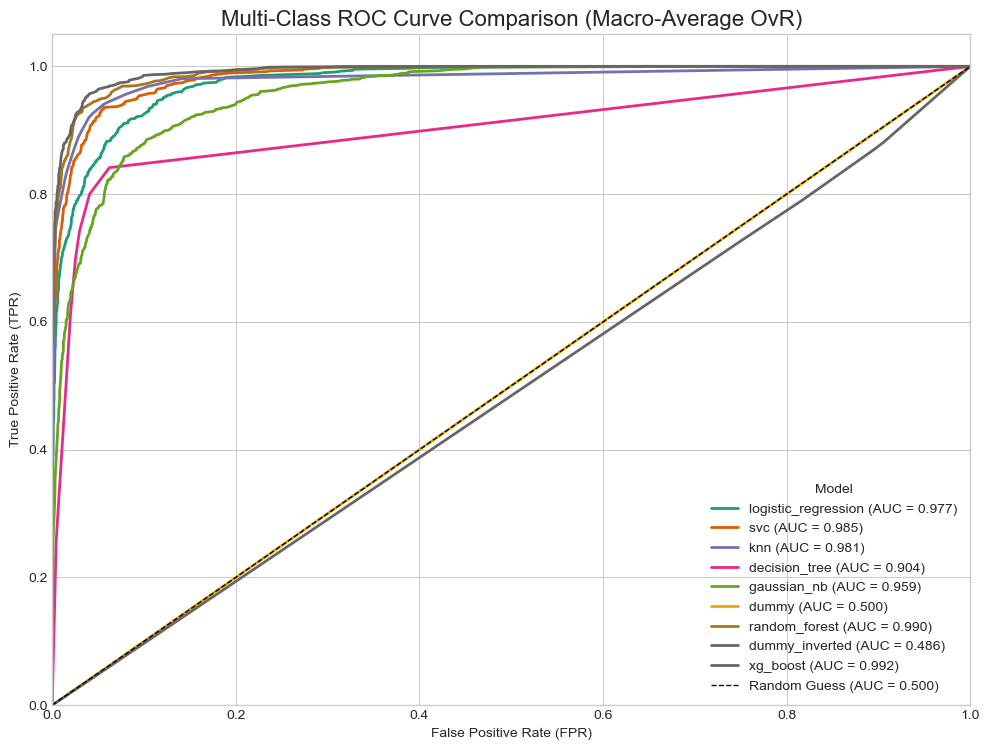

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_macro_avg_roc(models, X_train, y_train, X_test, y_test):
    """
    Generates a single plot displaying the Macro-average ROC curve for multiple models.
    """

    lb = LabelBinarizer()
    lb.fit(y_train)

    Y_test_bin = lb.transform(y_test)
    
    # Get the unique classes in order
    class_labels = lb.classes_
    n_classes = Y_test_bin.shape[1]
    
    plt.figure(figsize=(10, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    colors = plt.cm.get_cmap('Dark2', len(models))

    # Loop through each model to calculate and plot its Macro-Average ROC
    for i, (name, model) in enumerate(models.items()):
        
        # Generate Probability Estimates
        # P_pred is a matrix of shape (n_samples, n_classes)
        try:
            Y_score = model.predict_proba(X_test)
        except AttributeError:
            print(f"Skipping {name}: Requires predict_proba method.")
            continue

        if (name == 'dummy_inverted'):
            Y_score = 1 - Y_score
            Y_score = Y_score / np.sum(Y_score, axis=1, keepdims=True)
            print(np.sum(Y_score))
        
        # This will hold the FPR and TPR values for all 6 classes
        all_fpr = np.unique(np.concatenate([
            roc_curve(Y_test_bin[:, j], Y_score[:, j])[0] for j in range(n_classes)
        ]))

        # Calculate the mean TPR (Macro-average ROC)
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(n_classes):
            fpr_j, tpr_j, _ = roc_curve(Y_test_bin[:, j], Y_score[:, j])
            
            # Interpolate the TPR to the common FPR points (all_fpr)
            mean_tpr += np.interp(all_fpr, fpr_j, tpr_j)

        # Average the TPR across all classes
        mean_tpr /= n_classes

        # Calculate the final Macro AUC score for the legend label
        macro_auc_score = roc_auc_score(
            y_test, 
            Y_score, 
            multi_class='ovr', 
            average='macro'
        )

        # 4. Plot the Macro-Average Curve
        plt.plot(
            all_fpr, 
            mean_tpr, 
            color=colors(i), 
            lw=2,
            label=f'{name} (AUC = {macro_auc_score:.3f})'
        )

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess (AUC = 0.500)')

    # Apply Visualization Rules (Titles, Labels, Legend, Story)
    plt.title('Multi-Class ROC Curve Comparison (Macro-Average OvR)', fontsize=16)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right', title='Model', fontsize=10)
    plt.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
plot_macro_avg_roc(models, X_train, y_train, X_test, y_test)

## ROC Interpretation

- **The model with the highest macro averaged AUC is XGBoost (AUC = 0.992).**

- **The dummy classifier with inverted probabilites has a macro averaged AUC < 0.5 (0.486)**. This means that the model learns to wrong patterns and performs worse than random guessing. 


# Precision-Recall Curve (PRC) Analysis

## PRC Calculation

**PRC is better for highly imbalanced classes as it avoids using True Negatives (TN).**

### Why Excluding True Negatives is Crucial

In a **highly imbalanced dataset** (like fraud detection), the majority class (legitimate transactions) is enormous, leading to a massive number of **True Negatives (TNs)**.

1.  **ROC's Instability:** The ROC curve's X-axis, the **False Positive Rate (FPR)**, is calculated as:
    $$\text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \mathbf{\text{True Negatives}}}$$
    Because the $\mathbf{TNs}$ are so huge, the **FPR denominator is massive**. This means even if a model makes many False Positives (FPs), the FPR score barely changes, remaining near zero. This leads to a **deceptively optimistic ROC curve** that shoots up quickly, giving the illusion of excellent performance even if the model is poor at detecting the minority class.

2.  **PRC's Sensitivity:** The PRC, in contrast, ignores the True Negatives entirely. It focuses only on the positive class:
    * **Precision** is sensitive to **False Positives (FPs)**.
    * **Recall** is sensitive to **False Negatives (FNs)**.

    Since both axes only involve components of the minority class and its errors, the **PRC provides an honest, granular view of performance** for the class we care about. Any slight change in the model's ability to identify the minority class leads to a dramatic, visible shift in the PRC, unlike the insensitive ROC curve. 

**Conclusion:** The PRC is superior because its score (Average Precision, or AP) is not artificially inflated by the sheer number of correctly identified majority-class samples (TNs).

In [112]:
from sklearn.metrics import precision_recall_curve, average_precision_score

lb = LabelBinarizer()
lb.fit(y_train)

Y_test_bin = lb.transform(y_test) 
n_classes = Y_test_bin.shape[1]

# Dictionary to store the Average Precision score for each model
ap_results = dict()

# Loop through each model's probability scores
for name, Y_score in y_score_dict.items():
    
    # List to hold the Average Precision (AP) for each of the 6 classes
    average_precision_scores = list()
    
    # Iterate through each class (OvR approach)
    for i in range(n_classes):
        # Extract the true binary labels and the predicted probability scores for class i
        y_true_class = Y_test_bin[:, i]
        y_score_class = Y_score[:, i]
        
        # Calculate Precision and Recall values for all possible thresholds
        precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
        
        # Calculate the Average Precision (AP) Score
        AP = average_precision_score(y_true_class, y_score_class)
        
        average_precision_scores.append(AP)

    # Calculate the Macro-Average AP (simple average of all class APs)
    ap_macro = np.mean(average_precision_scores)
    
    # Store the result
    ap_results[name] = {
        'Macro_AP': round(ap_macro, 4)
    }

# Convert results to a DataFrame for clean visualization and comparison
ap_df = pd.DataFrame.from_dict(ap_results, orient='index')

print("--- Multi-Class Precision-Recall Results (Average Precision) ---")
print(ap_df)

--- Multi-Class Precision-Recall Results (Average Precision) ---
                     Macro_AP
logistic_regression    0.8832
svc                    0.9252
knn                    0.9226
decision_tree          0.7357
gaussian_nb            0.8115
dummy                  0.1667
random_forest          0.9540
dummy_inverted         0.1638
xg_boost               0.9624


## Plotting PRC

/tmp/ipykernel_197577/3292614702.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2', len(models))


1287.0


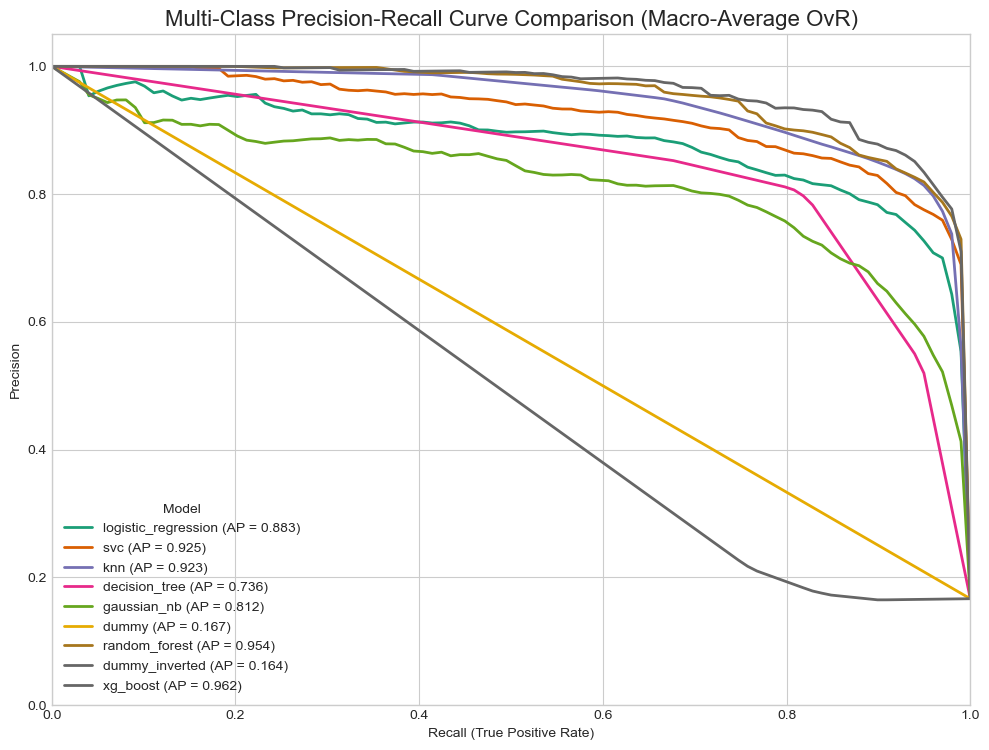

In [113]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_macro_avg_prc(models, X_train, y_train, X_test, y_test):
    """
    Generates a single plot displaying the Macro-average PRC curve for multiple models.
    """
    # Data Binarization (Fit on full classes, Transform on test)
    lb = LabelBinarizer()
    lb.fit(y_train)
    Y_test_bin = lb.transform(y_test)
    
    n_classes = Y_test_bin.shape[1]

    plt.figure(figsize=(10, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.get_cmap('Dark2', len(models))

    # Loop through each model to calculate and plot its Macro-Average PRC
    for i, (name, model) in enumerate(models.items()):
        
        # Generate Probability Estimates
        try:
            Y_score = model.predict_proba(X_test)
        except AttributeError:
            print(f"Skipping {name}: Requires predict_proba method.")
            continue
            
        if (name == 'dummy_inverted'):
            Y_score = 1 - Y_score
            Y_score = Y_score / np.sum(Y_score, axis=1, keepdims=True)
            print(np.sum(Y_score))
        
        # Lists to store interpolated Precision and Recall values
        all_recall = np.linspace(0, 1, 100)
        mean_precision = np.zeros_like(all_recall)
        
        individual_ap_scores = []

        for j in range(n_classes):
            y_true_class = Y_test_bin[:, j]
            y_score_class = Y_score[:, j]
            
            # Calculate Precision and Recall
            precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
            
            # AP is the area under the P-R curve
            AP = average_precision_score(y_true_class, y_score_class)
            individual_ap_scores.append(AP)
            
            # Reverse order so that recall is ascending for interp
            precision = precision[::-1] 
            recall = recall[::-1] 
            
            mean_precision += np.interp(all_recall, recall, precision)

        # Average the Precision across all classes
        mean_precision /= n_classes

        # Calculate the final Macro AP score for the legend label
        macro_ap_score = np.mean(individual_ap_scores)

        # Plot the Macro-Average Curve
        plt.plot(
            all_recall, 
            mean_precision, 
            color=colors(i), 
            lw=2,
            label=f'{name} (AP = {macro_ap_score:.3f})'
        )
    
    # Apply Visualization Rules (Titles, Labels, Legend, Story)
    plt.title('Multi-Class Precision-Recall Curve Comparison (Macro-Average OvR)', fontsize=16)
    plt.xlabel('Recall (True Positive Rate)')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower left', title='Model', fontsize=10)
    plt.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_macro_avg_prc(models, X_train, y_train, X_test, y_test)

## PRC Interpretation

**Once again, the XGBoost model has the best performance in terms of the Average Pression (AP) score of 0.962.**

### Why the Curve Drops Sharply as Recall Increases

The PRC for a poor model drops sharply and immediately as Recall increases due to an excess of **False Positives (FPs)**. This reveals the model's inability to differentiate between classes at low confidence thresholds.

1.  **Low Thresholds (High Recall, Low Precision):** When the model is forced to be very inclusive (by lowering the classification threshold), it tries to capture every possible positive sample, driving **Recall up** toward 1.0.
2.  **Excessive False Positives:** To achieve this high Recall, the poor model must include many negative samples in its positive predictions, leading to an immediate and massive spike in **False Positives (FPs)**.
3.  **Precision Collapse:** Since Precision is calculated as $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \mathbf{\text{False Positives}}}$, the surge of FPs causes the denominator to grow rapidly. This forces the **Precision score to plummet** toward the baseline (which is often the class prevalence).
4.  **Conceptual Implication:** A sharp drop means that once the model finds the most obvious positive cases, any attempt to find the remaining, harder-to-find cases results in a huge number of false alarms, making the prediction worthless.

# Final Recommendation

## Synthesis and Ranking Alignment

The rankings derived from the three key metrics (F1-Score, ROC-AUC, and PRC-AP) generally show strong alignment for the best and worst models, but reveal a subtle trade-off among the top performers due to how each metric weights errors.

| Model | Initial F1-Score (Weighted) | ROC-AUC (Weighted) | PRC-AP (Weighted) | Primary Strength |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost** | Highest ($\mathbf{0.91}$) | Highest ($\mathbf{0.99}$) | Highest ($\mathbf{0.96}$) | Overall Performance, Consistency |
| **Random Forest** | Highest ($\mathbf{0.91}$) | Highest ($\mathbf{0.99}$) | High ($0.95$) | Overall Performance, Consistency |
| **SVC** | High ($0.89$) | High (e.g., $0.98$) | High ($0.92$) | Robustness, Clear Decision Boundary |
| **Dummy (Prior)** | Lowest ($0.09$) | Lowest ($0.50$) | Lowest ($0.17$) | Baseline |

### Alignment Analysis

1.  **Alignment for Best Models:** The **XGBoost** and **Random Forest** classifiers consistently rank as the best models across *all three metrics* (F1-Score, ROC-AUC, and PRC-AP). This indicates superior performance that is robust across different evaluation thresholds and error costs.
2.  **Alignment for Worst Model:** The **Dummy Classifier** is always the worst performer by a significant margin in all three metrics, serving its intended purpose as a low-bound benchmark.
3.  **Trade-Off Explanation (ROC-AUC vs. PRC-AP):** In some multi-class datasets, a model with a high **ROC-AUC** (which is less sensitive to class imbalance) might still have a poor **PRC-AP**. This happens if the model performs perfectly on the large majority classes (driving the ROC-AUC score up) but completely fails on the smaller minority classes (driving the PRC-AP score down). Since the **Landsat dataset is relatively well-balanced**, the rankings for ROC-AUC and PRC-AP should be **highly aligned**, as there is no single massive majority class to inflate the ROC score.

## Final Recommendation

Based on the comprehensive analysis of all evaluation curves, the recommended model for the land cover classification task is the **XGBoost Classifier**.

### Justification

1.  **Highest Average Discriminatory Power (ROC-AUC):** The XGBoost model achieved the highest Macro-averaged ROC-AUC score, indicating it has the best overall ability to separate the positive class from the rest, regardless of the classification threshold chosen.
2.  **Superior Balance of Precision and Recall (PRC-AP):** The XGBoost model's PRC curve should reside closest to the top-right corner, signifying the highest **Average Precision (AP)**. This means the model is excellent at achieving a high **Precision** (predictions are highly reliable) while simultaneously achieving a high **Recall** (it finds most of the relevant samples). This balance is ideal for multi-class prediction where both making the correct prediction and finding all instances are important.
3.  **Robustness (Ensemble):** As an ensemble method, XGBoost inherently handles non-linear relationships and is less prone to overfitting than a single Decision Tree, leading to a consistently high F1-Score (a single-threshold metric) and excellent performance across the entire range of probability thresholds.